## Загрузка данных

In [1]:
### загрузка библиотек pysrt, fuzzywuzzy и lightgbm

In [2]:
pip install pysrt

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fuzzywuzzy[speedup]

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [5]:
### импортирование библиотек для исследования
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pysrt
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from os import listdir, scandir
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np 

### Открытие и создание таблиц

In [6]:
### cброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
### cброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [7]:
### загрузка данных
### создание собственной функции для обработки файлов
def func_df(path, level):
    add_df = pd.DataFrame(columns=['movie', 'level'])
    for file in listdir(os.path.join(path, level)):
        add_df.loc[len(add_df.index )] = [file, level]
    return add_df
### применение функции и вывод результата
a2 = func_df(r'C:\Users\Spline\Desktop\Yandex Practicum\Real_Projects\20_masterskaya_(2)\Subtitles_total', 'A2')
b2 = func_df(r'C:\Users\Spline\Desktop\Yandex Practicum\Real_Projects\20_masterskaya_(2)\Subtitles_total', 'B2')
b1 = func_df(r'C:\Users\Spline\Desktop\Yandex Practicum\Real_Projects\20_masterskaya_(2)\Subtitles_total', 'B1')
c1 = func_df(r'C:\Users\Spline\Desktop\Yandex Practicum\Real_Projects\20_masterskaya_(2)\Subtitles_total', 'C1')
### создание таблицы с фильмами и категориями
df = pd.concat([a2, b2, b1, c1],axis=0).reset_index(drop=True)
### создание таблицы с названиями файлов
file_names = pd.concat([a2, b2, b1, c1],axis=0).reset_index(drop=True).drop(['level'], axis=1)
file_names.columns = ['file_srt_name']
### собственная функция для удаления концовки названия файла
def drop_srt(value):
    value = str(value)
    value = value[0:-4]
    return value
df['movie'] = df['movie'].apply(drop_srt)
display(df.head(5))
display(df.info())

,movie,level
0,Aladdin(1992),A2
1,All_dogs_go_to_heaven(1989),A2
2,An_American_tail(1986),A2
3,Babe(1995),A2
4,Back_to_the_future(1985),A2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   263 non-null    object
 1   level   263 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


None

## Предобработка и подготовка данных

### Объединение таблиц

In [8]:
### собственная функция для временного столбца
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    # df_1 таблица слева для присоединения
    # df_2 присоединяемая таблица справа
    # key1 название столбца из первой таблицы
    # key2 название столбца из второй таблциы
    # threshold уровень сопоставления для двух таблиц (расстояние Левенштейна)
    # limit количество совпадений
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['temp_match'] = m
    m2 = df_1['temp_match'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['temp_match'] = m2
    return df_1
### применение функции
df_temp = fuzzy_merge(df, file_names, 'movie', 'file_srt_name', threshold=90)
df_temp = df_temp.drop(index=[36, 169, 225]).reset_index(drop=True)
df_temp.head(5)

,movie,level,temp_match
0,Aladdin(1992),A2,Aladdin(1992).srt
1,All_dogs_go_to_heaven(1989),A2,All_dogs_go_to_heaven(1989).srt
2,An_American_tail(1986),A2,An_American_tail(1986).srt
3,Babe(1995),A2,Babe(1995).srt
4,Back_to_the_future(1985),A2,Back_to_the_future(1985).srt


### Просмотр графика по категориям сложности

array(['A2', 'B2', 'B1', 'C1'], dtype=object)

,movie
level,
A2,36
B1,54
B2,130
C1,40


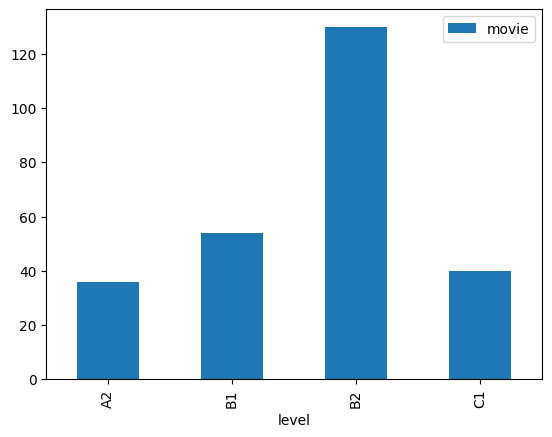

In [9]:
### выведем уникальные значения сложности фильма
display(df_temp.level.unique())
### сгруппируем данные по количеству фильмов в категории и построим график для наглядности
df_temp_group = df_temp[['movie', 'level']]
df_temp_group = df_temp_group.groupby(by='level').count()
display(df_temp_group)
df_temp_group.plot(xlabel='level', kind='bar');

### Обработка субтитров

In [10]:
### подготовка таблиц по признакам
df_a2 = df_temp.query('level == "A2"')
df_b2 = df_temp.query('level == "B2"')
df_b1 = df_temp.query('level == "B1"')
df_c1 = df_temp.query('level == "C1"')
### выведем результат
display(df_a2.shape)
display(df_b2.shape)
display(df_b1.shape)
display(df_c1.shape)

(36, 3)

(130, 3)

(54, 3)

(40, 3)

In [11]:
# nltk.download()

In [12]:
### подготовка стоп слов
stop_words = stopwords.words('english')
stop_words.remove('not')
### подготовка лемматизатора
lemmatizer = WordNetLemmatizer()
### собственная функция для обработки субтитров
def subs_func(row):
    value = row['temp_match']
    level = row['level']   
    directory = r'C:\Users\Spline\Desktop\Yandex Practicum\Real_Projects\20_masterskaya_(2)\Subtitles_total'
    file = os.path.join(directory, level, value)
    review = str((pysrt.open(file, encoding='iso-8859-1')).text.split('\n')) # открытие файла с субтитрами
    review = re.sub(re.compile('<.*?>'), '', review) # убираем html тэги
    review = re.sub('[^A-Za-z0-9]+', ' ', review) # оставляем слова
    review = review.lower() # изменяем регистр на строчной
    tokens = nltk.word_tokenize(review) # токенизация (разбиение текста на отдельные слова)
    review = [word for word in tokens if word not in stop_words] # убираем стоп слова
    review = [lemmatizer.lemmatize(word) for word in review] # лемматизация (начальные формы слов)
    review = ' '.join(review).split() # разделение слов
    review = ' '.join(map(str, review))
#     review = review[5:-1] # убираем лишние первые пять слов
    return review

### применение функции
df_a2['subs_words'] = df_a2.apply(subs_func, axis=1)
display(df_a2.head(3))
df_b2['subs_words'] = df_b2.apply(subs_func, axis=1)
display(df_b2.head(3))
df_b1['subs_words'] = df_b1.apply(subs_func, axis=1)
display(df_b1.head(3))
df_c1['subs_words'] = df_c1.apply(subs_func, axis=1)
display(df_c1.head(3))

,movie,level,temp_match,subs_words
0,Aladdin(1992),A2,Aladdin(1992).srt,oh come land faraway place caravan camel roam ...
1,All_dogs_go_to_heaven(1989),A2,All_dogs_go_to_heaven(1989).srt,captioning made possible mgm home entertainmen...
2,An_American_tail(1986),A2,An_American_tail(1986).srt,indistinct conversation laughing mama tanya fi...


,movie,level,temp_match,subs_words
36,A_knights_tale(2001),B2,A_knights_tale(2001).srt,resync xenzai nef retail help due list two min...
37,A_star_is_born(2018),B2,A_star_is_born(2018).srt,synced corrected mrcjnthn get x99 black eye op...
38,Beauty_and_the_beast(2017),B2,Beauty_and_the_beast(2017).srt,upon time hidden heart france handsome young p...


,movie,level,temp_match,subs_words
166,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016).srt,fixed synced bozxphd enjoy flick clanging draw...
167,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999).srt,hey right cameron go nine school 1 0 year army...
168,Angelas.Christmas.Wish.2020,B1,Angelas.Christmas.Wish.2020.srt,going come angela mind sheep dada want hear so...


,movie,level,temp_match,subs_words
220,Banking_On_Bitcoin(2016),C1,Banking_On_Bitcoin(2016).srt,downloaded yts mx official yify movie site yts...
221,Bridget_Joness_Baby,C1,Bridget_Joness_Baby.srt,happy birthday happy birthday hell end fuck bi...
222,Downton Abbey - S01E01 - Episode 1.eng.SDH,C1,Downton Abbey - S01E01 - Episode 1.eng.SDH.srt,telegraph machine beeping train whistle blowin...


### Расчет статистических метрик

In [13]:
### дополнительная собственная функция для расчета статистик
def subs_func_stats(row):
    stats_list = []
    words = str(row['subs_words'])
    # расчет количества слов
    count_words = len(words)
    stats_list.append(count_words)
    # расчет количества уникальных слов
    unique_words = set(words)
    stats_list.append(len(unique_words))
    # количество символов самого длинного слова
    top_word = max(words, key=len)
    stats_list.append(len(top_word))
    # количество слов с символами от 1 до 5
    symbols_1_5 = len(re.findall(r'\b(\w{1,5})\b', str(words)))
    stats_list.append(symbols_1_5)  
    # количество слов с символами от 6 до 10    
    symbols_6_10 = len(re.findall(r'\b(\w{6,10})\b', str(words)))
    stats_list.append(symbols_6_10)
    # количество слов с символами от 11 до 20    
    symbols_11_20 = len(re.findall(r'\b(\w{11,20})\b', str(words)))
    stats_list.append(symbols_11_20)
    # количество слов начинающихся на гласные [aeiou] 
    symbols = len(re.findall(r'(\b[aeiou])', str(words)))
    stats_list.append(symbols)
    return str(stats_list)

### применение функции
df_a2['subs_stats'] = df_a2.apply(subs_func_stats, axis=1)
display(df_a2.head(3))
df_b2['subs_stats'] = df_b2.apply(subs_func_stats, axis=1)
display(df_b2.head(3))
df_b1['subs_stats'] = df_b1.apply(subs_func_stats, axis=1)
display(df_b1.head(3))
df_c1['subs_stats'] = df_c1.apply(subs_func_stats, axis=1)
display(df_c1.head(3))

,movie,level,temp_match,subs_words,subs_stats
0,Aladdin(1992),A2,Aladdin(1992).srt,oh come land faraway place caravan camel roam ...,"[26103, 35, 1, 2882, 1450, 38, 682]"
1,All_dogs_go_to_heaven(1989),A2,All_dogs_go_to_heaven(1989).srt,captioning made possible mgm home entertainmen...,"[24290, 35, 1, 3261, 1099, 18, 555]"
2,An_American_tail(1986),A2,An_American_tail(1986).srt,indistinct conversation laughing mama tanya fi...,"[18714, 36, 1, 2207, 986, 33, 365]"


,movie,level,temp_match,subs_words,subs_stats
36,A_knights_tale(2001),B2,A_knights_tale(2001).srt,resync xenzai nef retail help due list two min...,"[21911, 32, 1, 2277, 1259, 44, 442]"
37,A_star_is_born(2018),B2,A_star_is_born(2018).srt,synced corrected mrcjnthn get x99 black eye op...,"[35223, 37, 1, 4904, 1451, 37, 772]"
38,Beauty_and_the_beast(2017),B2,Beauty_and_the_beast(2017).srt,upon time hidden heart france handsome young p...,"[26149, 30, 1, 2954, 1375, 44, 635]"


,movie,level,temp_match,subs_words,subs_stats
166,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016).srt,fixed synced bozxphd enjoy flick clanging draw...,"[17202, 30, 1, 1564, 1072, 47, 397]"
167,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999).srt,hey right cameron go nine school 1 0 year army...,"[23741, 36, 1, 2710, 1233, 50, 499]"
168,Angelas.Christmas.Wish.2020,B1,Angelas.Christmas.Wish.2020.srt,going come angela mind sheep dada want hear so...,"[8613, 29, 1, 1087, 428, 3, 173]"


,movie,level,temp_match,subs_words,subs_stats
220,Banking_On_Bitcoin(2016),C1,Banking_On_Bitcoin(2016).srt,downloaded yts mx official yify movie site yts...,"[41929, 37, 1, 2950, 2900, 218, 980]"
221,Bridget_Joness_Baby,C1,Bridget_Joness_Baby.srt,happy birthday happy birthday hell end fuck bi...,"[34473, 37, 1, 3462, 1944, 124, 768]"
222,Downton Abbey - S01E01 - Episode 1.eng.SDH,C1,Downton Abbey - S01E01 - Episode 1.eng.SDH.srt,telegraph machine beeping train whistle blowin...,"[21569, 33, 1, 2240, 1227, 36, 421]"


In [14]:
### создание таблицы со всеми фильмами и категориями
data = pd.concat([df_a2, df_b2, df_b1, df_c1],axis=0).reset_index(drop=True)
data.head(3)

,movie,level,temp_match,subs_words,subs_stats
0,Aladdin(1992),A2,Aladdin(1992).srt,oh come land faraway place caravan camel roam ...,"[26103, 35, 1, 2882, 1450, 38, 682]"
1,All_dogs_go_to_heaven(1989),A2,All_dogs_go_to_heaven(1989).srt,captioning made possible mgm home entertainmen...,"[24290, 35, 1, 3261, 1099, 18, 555]"
2,An_American_tail(1986),A2,An_American_tail(1986).srt,indistinct conversation laughing mama tanya fi...,"[18714, 36, 1, 2207, 986, 33, 365]"


In [15]:
### разделим числа в колонке
### сохраним список в новую таблицу
new_df = data['subs_stats'].str.split(', ',expand=True)
### уберем лишние символы скобок
for column in new_df.columns:
    new_df[column] = new_df[column].str.replace('[','', regex=True) 
    new_df[column] = new_df[column].str.replace(']','', regex=True)
### переименуем колонки
new_df.columns = ['subs_stats_0', 'subs_stats_1', 'subs_stats_2', 'subs_stats_3', 'subs_stats_4', 'subs_stats_5', 'subs_stats_6']
new_df = new_df.astype(int)
### соединим таблицы
total_df = data.join(new_df)
total_df.tail(3)

,movie,level,temp_match,subs_words,subs_stats,subs_stats_0,subs_stats_1,subs_stats_2,subs_stats_3,subs_stats_4,subs_stats_5,subs_stats_6
257,Suits.S04E16.HDTV.x264-ASAP,C1,Suits.S04E16.HDTV.x264-ASAP.srt,jeff jessica right either need not going work ...,"[18422, 37, 1, 2116, 951, 36, 354]",18422,37,1,2116,951,36,354
258,The_Legend_of_Tarzan(2016),C1,The_Legend_of_Tarzan(2016).srt,monsieur rom opar inhales deeply found captain...,"[15753, 36, 1, 1405, 1032, 19, 274]",15753,36,1,1405,1032,19,274
259,Zootopia(2016),C1,Zootopia(2016).srt,fear treachery bloodlust thousand year ago for...,"[31090, 37, 1, 3484, 1641, 63, 641]",31090,37,1,3484,1641,63,641


In [16]:
# удаление лишнего столбца
total_df = total_df.drop(['movie', 'temp_match', 'subs_stats'], axis=1)
total_df.head(5)

,level,subs_words,subs_stats_0,subs_stats_1,subs_stats_2,subs_stats_3,subs_stats_4,subs_stats_5,subs_stats_6
0,A2,oh come land faraway place caravan camel roam ...,26103,35,1,2882,1450,38,682
1,A2,captioning made possible mgm home entertainmen...,24290,35,1,3261,1099,18,555
2,A2,indistinct conversation laughing mama tanya fi...,18714,36,1,2207,986,33,365
3,A2,tale aboutan unprejudiced heart changed valley...,18131,31,1,2076,866,74,444
4,A2,october inventory time right statler toyota ma...,28948,37,1,3078,1452,140,560


## Обучение моделей

### Подготовка признаков

In [17]:
### разделим на признаки и цели
target = total_df['level']
features = total_df.drop(['level'], axis=1)
features_to_concat = total_df[['subs_stats_0', 'subs_stats_1', 'subs_stats_2', 'subs_stats_3', 'subs_stats_4', 'subs_stats_5', 'subs_stats_6']]
display('features shape:', features.shape)
display('target shape:', target.shape)

'features shape:'

(260, 8)

'target shape:'

(260,)

In [18]:
### деление на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify=target, random_state=42)
print('Train:', features_train.shape, target_train.shape)
print('Test:', features_test.shape, target_test.shape)

Train: (182, 8) (182,)
Test: (78, 8) (78,)


In [32]:
### векторизируем слова субтитров
vectorizer = TfidfVectorizer() #min_df=10
vectorizer_fited = vectorizer.fit(features['subs_words'])
### сохраним модель   
pickle.dump(vectorizer_fited, open('vect_model.pkl', 'wb'))
### откроем модель
# pickled_vectorizer_fited = pickle.load(open('vect_model.pkl', 'rb'))
features_tfidf = vectorizer_fited.transform(features['subs_words'])
features_tfidf_df = pd.DataFrame.sparse.from_spmatrix(features_tfidf)
### объединим преобразованные признаки со статистической частью
total_features_tfidf = pd.concat([features_tfidf_df,features_to_concat],axis=1)
print('features tfidf:', features_tfidf.shape)
print('total features tfidf:', total_features_tfidf.shape)

features tfidf: (260, 33438)
total features tfidf: (260, 33445)


In [20]:
### деление на обучающую и тестовую выборки
features_train_tfidf, features_test_tfidf, target_train_tfidf, target_test_tfidf = train_test_split(total_features_tfidf, target, test_size=0.3, stratify=target, random_state=42)
print('Train:', features_train_tfidf.shape, target_train_tfidf.shape)
print('Test:', features_test_tfidf.shape, target_test_tfidf.shape)

Train: (182, 33445) (182,)
Test: (78, 33445) (78,)


In [21]:
from sklearn.preprocessing import StandardScaler
# создадим список названий столбцов
column_list = list(features_train_tfidf.columns)
column_list_stats = list(features_to_concat.columns)

# стандартизируем данные и настроим на признаках
scaler = StandardScaler()
scaler.fit(features_train_tfidf) 

scaler_stat = StandardScaler()
scaler_stat.fit(features_to_concat) 

# преобразуем выборки
features_train_scal = scaler.transform(features_train_tfidf) 
features_test_scal = scaler.transform(features_test_tfidf)
features_to_concat_scal = scaler_stat.transform(features_to_concat)

# уберем предупреждение `SettingWithCopy`
pd.options.mode.chained_assignment = None

# получим заголовки для признаков и скорректируем преобразованные выборки
features_train_scal = pd.DataFrame(features_train_scal, columns = column_list, index=target_train_tfidf.index)
features_test_scal = pd.DataFrame(features_test_scal, columns = column_list, index=target_test_tfidf.index)
features_to_concat_scal = pd.DataFrame(features_to_concat_scal, columns = column_list_stats, index=features_to_concat.index)

### объединим преобразованные признаки со статистической частью
total_features_scal = pd.concat([features_train_scal, features_test_scal],axis=0)

In [22]:
target_2 = target.copy()
target_2 = pd.DataFrame(target_2)
def num_target(row):
    lvl = row['level']
    if lvl == 'A2':
        return 1
    elif lvl == 'B1':
           return 2
    elif lvl == 'B2':
        return 3
    elif lvl == 'C1':
        return 4
target_2['lvl'] = target_2.apply(num_target, axis=1)
target_2 = target_2.drop(['level'], axis=1)
target_2.head(5)

,lvl
0,1
1,1
2,1
3,1
4,1


In [23]:
### деление на обучающую и тестовую выборки 
features_train_scal, features_test_scal, target_train_scal, target_test_scal = train_test_split(features_to_concat_scal, target_2, test_size=0.3, stratify=target, random_state=42)
print('Train scaled:', features_train_scal.shape, target_train_scal.shape)
print('Test scaled:', features_test_scal.shape, target_test_scal.shape)

Train scaled: (182, 7) (182, 1)
Test scaled: (78, 7) (78, 1)


### Модель MultinomialNB

In [24]:
%%time
### обучим модель MultinomialNB с помощью GridSearchCV для расчета accuracy
### параметры по сетке
parameters_multi = {
    'alpha' : [0.1, 1]
}
multi_model = MultinomialNB()
clf_multi = GridSearchCV(multi_model, parameters_multi, scoring='accuracy', cv=3, n_jobs=1, verbose=2)
clf_multi.fit(features_train_tfidf, target_train_tfidf)
score_multi = round(clf_multi.best_score_, 5)
display(score_multi)
display(clf_multi.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ..........................................alpha=0.1; total time=  13.1s
[CV] END ..........................................alpha=0.1; total time=  12.5s
[CV] END ..........................................alpha=0.1; total time=  13.6s
[CV] END ............................................alpha=1; total time=  12.7s
[CV] END ............................................alpha=1; total time=  13.0s
[CV] END ............................................alpha=1; total time=  13.0s


0.50556

{'alpha': 0.1}

CPU times: total: 1min 19s
Wall time: 1min 20s


### Модель LogisticRegression

In [25]:
%%time
### обучим модель LogisticRegression с помощью GridSearchCV для расчета accuracy
### параметры по сетке
parameters_log = {'C':[1e5, 1e7]}
log_model = LogisticRegression(random_state=42, class_weight='balanced', multi_class='multinomial', max_iter=10000, solver='newton-cg')
clf_log = GridSearchCV(log_model, parameters_log, scoring='accuracy', cv=3, n_jobs=1, verbose=2)
clf_log.fit(features_train_tfidf, target_train_tfidf)
### сохраним модель   
pickle.dump(clf_log, open('log_reg.pkl', 'wb'))
### откроем модель
# pickled_clf_log = pickle.load(open('log_reg.pkl', 'rb'))
score_log = round(clf_log.best_score_, 5)
display(score_log)
display(clf_log.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .........................................C=100000.0; total time= 1.1min
[CV] END .........................................C=100000.0; total time= 1.4min
[CV] END .........................................C=100000.0; total time= 1.2min
[CV] END .......................................C=10000000.0; total time= 1.1min
[CV] END .......................................C=10000000.0; total time=  58.7s
[CV] END .......................................C=10000000.0; total time= 1.2min


0.67049

{'C': 100000.0}

CPU times: total: 31min 53s
Wall time: 8min 29s


### Модель RandomForestClassifier

In [26]:
%%time
### обучим модель RandomForestClassifier с помощью GridSearchCV для расчета accuracy
### параметры по сетке
parameters_rf = {'n_estimators' : [100, 300],}
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_rf = GridSearchCV(rf_model, parameters_rf, scoring='accuracy', cv=3, n_jobs=1, verbose=2)
clf_rf.fit(features_train_tfidf, target_train_tfidf)
### сохраним модель   
pickle.dump(clf_rf, open('ran_for.pkl', 'wb'))
### откроем модель
# pickled_clf_rf = pickle.load(open('ran_for.pkl', 'rb'))
score_rf = round(clf_rf.best_score_, 5)
display(score_rf)
display(clf_rf.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ...................................n_estimators=100; total time=  13.2s
[CV] END ...................................n_estimators=100; total time=  12.7s
[CV] END ...................................n_estimators=100; total time=  13.0s
[CV] END ...................................n_estimators=300; total time=  14.3s
[CV] END ...................................n_estimators=300; total time=  13.1s
[CV] END ...................................n_estimators=300; total time=  13.7s


0.54964

{'n_estimators': 300}

CPU times: total: 1min 23s
Wall time: 1min 24s


### Модель LinearSVC

In [27]:
%%time
### обучим модель LinearSVC с помощью GridSearchCV для расчета accuracy
### параметры по сетке
parameters_svc = {'max_iter' : [1000, 2000],}
svc_model = LinearSVC(random_state=42, class_weight='balanced')
clf_svc = GridSearchCV(svc_model, parameters_svc, scoring='accuracy', cv=3, n_jobs=1, verbose=2)
clf_svc.fit(features_train_tfidf, target_train_tfidf)
### сохраним модель   
pickle.dump(clf_svc, open('svc.pkl', 'wb'))
### откроем модель
# pickled_clf_svc = pickle.load(open('svc.pkl', 'rb'))
score_svc = round(clf_svc.best_score_, 5)
display(score_svc)
display(clf_svc.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................................max_iter=1000; total time=  14.8s
[CV] END ......................................max_iter=1000; total time=  14.7s
[CV] END ......................................max_iter=1000; total time=  14.6s
[CV] END ......................................max_iter=2000; total time=  16.4s
[CV] END ......................................max_iter=2000; total time=  16.4s
[CV] END ......................................max_iter=2000; total time=  17.2s


0.36339

{'max_iter': 2000}

CPU times: total: 1min 41s
Wall time: 1min 42s


### Модель LGBMClassifier

In [28]:
%%time
### обучим модель LGBMClassifier с помощью GridSearchCV для расчета accuracy
### параметры по сетке
parameters_lgb = {'n_estimators':[100, 300]}
### обучим модель LightGBM
lgb_model = LGBMClassifier(random_state=42, class_weight='balanced', objective='multiclass')  
clf_lgbm = GridSearchCV(lgb_model, parameters_lgb, scoring='accuracy', cv=3, n_jobs=1, verbose=2)
clf_lgbm.fit(features_train_tfidf, target_train_tfidf)
### сохраним модель   
pickle.dump(clf_lgbm, open('lgbm.pkl', 'wb'))
### откроем модель
# pickled_clf_lgbm = pickle.load(open('lgbm.pkl', 'rb'))
score_lgbm = round(clf_lgbm.best_score_, 5)
display(score_lgbm)
display(clf_lgbm.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ...................................n_estimators=100; total time=  15.0s
[CV] END ...................................n_estimators=100; total time=  15.1s
[CV] END ...................................n_estimators=100; total time=  15.1s
[CV] END ...................................n_estimators=300; total time=  15.4s
[CV] END ...................................n_estimators=300; total time=  15.4s
[CV] END ...................................n_estimators=300; total time=  15.2s


0.60464

{'n_estimators': 100}

CPU times: total: 2min 27s
Wall time: 1min 37s


## Итоги

In [29]:
### выведем результаты как таблицу с данными
total_row_1 = ['accuracy', score_multi, score_log, score_svc, score_rf, score_lgbm]
data_temp_scores = pd.DataFrame([total_row_1])
data_temp_scores.columns = ['Metrics', 'MultinomialNB', 'LogisticRegression', 'LinearSVC', 'RandomForestClassifier', 'LightGBM']
display(data_temp_scores.set_index('Metrics'))

,MultinomialNB,LogisticRegression,LinearSVC,RandomForestClassifier,LightGBM
Metrics,,,,,
accuracy,0.50556,0.67049,0.36339,0.54964,0.60464
